
$$
\newcommand{\ytrue}{\mathbf{y_{\textbf{true}}}}
\newcommand{\yprob}{\mathbf{y_{\textbf{prob}}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\x}{\mathbf{x}}
$$

## Cross-Entropy as a Loss Function

### Intuition

We need to make sense of entropy in the form of a loss function, we have to just enhance our thinking a little.

We define our target to be a one-hot encoded vector of class 0 and 1.

```python
target = [0, 1]
```

Intuitively, take the cat vs dog binary classification again, we made 11 predictions for ONLY ONE query image using different model, and find that after going through many layers, the **softmax** predictions on the logits are as such:

```python
[
    [0.0, 1.0],
    [0.1, 0.9],
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5],
    [0.6, 0.4],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.9, 0.1],
    [1.0, 0.0],
]
```

where the first index corresponds to the logits of class 0 and second index corresponds to the logits of class 1. 


For example, `[1, 0]` means the model is 100 percent confident the prediction is a class 0 (cat), and obviously we need to punish the model for spitting nonsense like this.


As we can see in the `binary_cross_entropy` function below, we only need to add up two things. And note that we are hinging on class 1 and therefore `y_true[0] * log(y_pred[0]+eps)` goes to 0 as we are just relying on our feedback of probability of class 1.

And in our graph, we can see that as predictions gets more wrong, meaning to say, if the query image is a dog, but our predictions is `[1, 0]`, which says it is a cat, our entropy loss will blow up to very high because 

```python
y_true[1] * log(y_pred[1]+eps) -> 1 * log(1+eps) -> almost infinity
```

Note again we do not calculate for class 0 because 

1. We one-hot encoded.
2. We only look at class 1's probability and that's enough as we can deduce class 0's probability anyways.

And conversely, note how the entropy loss goes to 0 if our prediction is say `[0, 1]`. In general, as our probability for the query image gets close to 1, or in agreement with our class, then our entropy loss becomes smaller.




### Cross-Entropy on one Example

We first understand the idea and intuition of **Cross-Entropy Loss** on one single example. Consider a dataset of cat (class 0) and dogs (class 1) where after one hot encoding we have class 0 to be $[1, 0]$ and class 1 to be $[0, 1]$.

We are given the following:

- $\mathcal{D}$: The dataset.
- $\mathbf{x}_q$: One single query image (i.e one image only). This can be a **random variable**.
- $\mathbf{y}_q$: The corresponding label - dog (class 1) which is $[0, 1]$. 
- $P$: The probability distribution for the ground truth target - which is $[0, 1]$, one can understand it as the distribution where cat's probability is 0, and dog's probability is 1. 
- $Q$: The probability distribtion of the estimate on the $\mathbf{x}_q$, which is say, $[0.1, 0.9]$. 

Thus, we can compute the cross entropy loss of this single image by:





In [1]:
import numpy as np
import torch

import torch.nn.functional as F
torch.__version__

'1.10.1+cpu'

In [ ]:
def torch_to_np(tensor: torch.Tensor) -> np.ndarray:
    """Convert a PyTorch tensor to a numpy array.

    Args:
        tensor (torch.Tensor): The PyTorch tensor to convert.

    Returns:
        np.ndarray: The converted numpy array.
    """
    return tensor.detach().cpu().numpy()

def compare_equality_two_tensors(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> bool:
    """Compare two PyTorch tensors for equality.

    Args:
        tensor1 (torch.Tensor): The first PyTorch tensor to compare.
        tensor2 (torch.Tensor): The second PyTorch tensor to compare.

    Returns:
        bool: Whether the two tensors are equal.
    """
    if torch.all(torch.eq(tensor1, tensor2)):
        return True
    return False


def compare_closeness_two_tensors(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor,
    epsilon: float,
    *args,
    **kwargs
) -> bool:
    """Compare two PyTorch tensors for closeness.

    Args:
        tensor1 (torch.Tensor): The first PyTorch tensor to compare.
        tensor2 (torch.Tensor): The second PyTorch tensor to compare.
        epsilon (float): The epsilon value to use for closeness.

    Returns:
        bool: Whether the two tensors are close.
    """
    if torch.allclose(tensor1, tensor2, atol=epsilon, *args, **kwargs):
        return True
    return False

In [9]:
z_logits = torch.tensor([[1, 2, 3], [2, 4, 6]], dtype=torch.float32)

y_true = torch.tensor([0, 2], dtype=torch.long)

y_true_ohe = torch.tensor([[1, 0, 0], [0, 0, 1]], dtype=torch.long)
compare_equality_two_tensors(y_true_ohe, torch.nn.functional.one_hot(y_true, num_classes=3))

True

In [16]:
def compute_softargmax(z: torch.Tensor) -> torch.Tensor:
    """Compute the softargmax of a PyTorch tensor.

    Args:
        z (torch.Tensor): The PyTorch tensor to compute the softargmax of.

    Returns:
        torch.Tensor: The softargmax of the PyTorch tensor.
    """

    # the output matrix should be the same size as the input matrix
    z_softargmax = torch.zeros(size=z.size(), dtype=torch.float32)

    for row_index, each_row in enumerate(z):
        denominator = torch.sum(torch.exp(each_row))
        for element_index, each_element in enumerate(each_row):
            z_softargmax[row_index, element_index] = (
                torch.exp(each_element) / denominator
            )

    assert compare_closeness_two_tensors(
        z_softargmax, torch.nn.Softmax(dim=1)(z), 1e-15
    )
    return z_softargmax

In [28]:
z_softargmax = compute_softargmax(z_logits)

In [18]:
torch.nn.CrossEntropyLoss()(z_logits, y_true)

tensor(1.2753)

In [19]:
z_logits

tensor([[1., 2., 3.],
        [2., 4., 6.]])

In [29]:
z_softargmax

tensor([[0.0900, 0.2447, 0.6652],
        [0.0159, 0.1173, 0.8668]])

In [20]:
y_true_ohe

tensor([[1, 0, 0],
        [0, 0, 1]])

In [34]:
(-1 * torch.log(z_softargmax)).T

tensor([[2.4076, 4.1429],
        [1.4076, 2.1429],
        [0.4076, 0.1429]])

In [47]:
m = y_true_ohe.float().matmul((-1 * torch.log(z_softargmax)).T)
m

tensor([[2.4076, 4.1429],
        [0.4076, 0.1429]])

In [69]:
torch.diagonal(m, 0).sum()

tensor(2.5505)

### Categorical Cross Entropy Loss

We will start with this because the Binary Cross Entropy Loss is merely a special case of this. Finding the full compact formula for this took me a while since most tutorials cover the binary case.

Given $N$ samples, and $C$ classes, the **Categorical Cross Entropy Loss** is the average loss across $N$ samples, given by:

$$\textbf{CE}(\ytrue, \yprob) = -\dfrac{1}{N}\sum_{i=1}^N\sum_{c=1}^C \mathbb{1}_{\y_{i} \in C_c} \log\left(p_{\textbf{model}}[\y_i \in C_c]\right)$$

where

- The outer loop $i$ iterates over $N$ observations/samples.
- The inner loop $c$ iterates over $C$ classes.
- $\y_i$ represents the true label (in this formula it should be one-hot encoded) of the $i$-th sample.
- $\mathbb{1}_{y_{i} \in C_c}$ is an indicator function, simply put, for sample $i$, if the true label $\y_i$ belongs to the $c$-th category, then we assign a $1$, else $0$. We can see it with an example later.
- $\left(p_{\textbf{model}}[\y_i \in C_c]\right)$ means the probability predicted by the model for the $i$-th observation that belongs to the $c$-th class category. 

$$
\ytrue = \begin{bmatrix}  1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

$$
\textbf{z_logits} = \begin{bmatrix} 1 & 2 & 3 \\ 2 & 4 & 6 \end{bmatrix}
$$

$$
\yprob = \textbf{z_softargmax} = \begin{bmatrix} 0.09 & 0.2447 & 0.6652 \\ 0.0159 & 0.1173 & 0.8668\end{bmatrix}
$$



- We first look at the first sample, index $i = 1$:
    - We have the one-hot encoded label for first sample to be $\y_1 = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix}$. This means the label is a cat since the sequence is cat, dog and pig, and thus 1, 0, 0 corresponds to cat 1, dog 0 and pig 0.
    - We have the one-hot encoded probability predicted by the model for the first sample to be $\hat{\y_1} = \begin{bmatrix} 0.09 & 0.2447 & 0.6652 \end{bmatrix}$. This means the probability associated with this sample $1$ is probability of a cat from the model is $9\%$, a dog $24.47\%$ and a pig $66.52\%$.
    
---

- With these information, we go on to the first outer loop's content:
    - $\sum_{c=1}^C \mathbb{1}_{\y_{i} \in C_c} \log\left(p_{\textbf{model}}[\y_i \in C_c]\right)$
    - We are looping through the classes, which in this case is loop from $c=1$ to $c=3$ since $C=3$ (3 classes).
    - $c = 1$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{1} \in C_1}$: The true label for the first sample is actually the first class, and hence belongs to the $c=1$ category, so our indicator function returns me a $1$. 
        - $\log\left(p_{\textbf{model}}[\y_i \in C_c]\right) = \log\left(p_{\textbf{model}}[\y_1 \in C_1]\right)$: Applies the log function (natural log here) to the each probability associated with the class. So in this case, since $c=1$, we apply the log function to the first entry $0.09$. We get $\log(0.09) = -2.4079$
    - $c = 2$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{1} \in C_2}$: The true label for the first sample is actually the first class, and hence does not belong to the $c=2$ category, so our indicator function returns me a $0$. 
        - Regardless, the log of this probability is $\log(0.2447) = -1.4076$
    - $c = 3$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{1} \in C_3}$: The true label for the first sample is actually the first class, and hence does not belong to the $c=3$ category, so our indicator function returns me a $0$. 
        - Regardless, the log of this probability is $\log(0.6652) = -0.4076$
    - Lastly, we sum them up and get $-2.4076 + 0 + 0 = -2.4076$, note here we only have the first entry! The second and third are $0$.
    - In code, this corresponds to the following:
        ```python
            # loop = 1
            current_sample_loss = 0
            for each_y_true_element, each_y_prob_element in zip(
                each_y_true_one_hot_vector, each_y_prob_one_hot_vector
            ):
                # Indicator Function
                if each_y_true_element == 1:
                    current_sample_loss += -1 * torch.log(each_y_prob_element)
                else:
                    current_sample_loss += 0
        ```
    - Bonus: If you realize this is just a vector dot product: $\begin{bmatrix} 1 & 0 & 0 \end{bmatrix} \cdot \log\left(\begin{bmatrix} 0.09 \\ 0.2447 \\ 0.6652 \end{bmatrix}\right) = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} \cdot \left(\begin{bmatrix} -2.4076 \\ -1.4076 \\ -0.4076 \end{bmatrix}\right) = -2.4076$
    
---


- We now look at the second sample, index $i = 2$:
    - We have the one-hot encoded label for second sample to be $\y_2 = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$. This means the label is a pig since the sequence is cat, dog and pig, and thus 0, 0, 1 corresponds to cat 0, dog 0 and pig 1.
    - We have the one-hot encoded probability predicted by the model for the second sample to be $\hat{\y_2} = \begin{bmatrix} 0.0159 & 0.1173 & 0.8868 \end{bmatrix}$. This means the probability associated with this sample $2$ is probability of a cat from the model is $1.59\%$, a dog $11.73\%$ and a pig $88.68\%$.
    
---

- With these information, we go on to the second outer loop's content:
    - $\sum_{c=2}^C \mathbb{1}_{\y_{i} \in C_c} \log\left(p_{\textbf{model}}[\y_i \in C_c]\right)$
    - $c = 2$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{2} \in C_1}$: The true label for the second sample is actually the third class, and hence belongs to the $c=3$ category, so our indicator function returns me a $0$. 
        - $\log\left(p_{\textbf{model}}[\y_i \in C_c]\right)$: Applies the log function (natural log here) to the each probability associated with the class. So in this case, since $c=1$, we apply the log function to the first entry $0.0159$. We get $\log(0.0159) = -4.1429$
    - $c = 2$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{2} \in C_2}$: The true label for the second sample is actually the third class, and hence does not belong to the $c=2$ category, so our indicator function returns me a $0$. 
        - Regardless, the log of this probability is $\log(0.1173) = -2.1429$
    - $c = 3$:
        - $\mathbb{1}_{\y_{i} \in C_c} = \mathbb{1}_{\y_{2} \in C_3}$: The true label for the second sample is actually the third class, so our indicator function returns me a $1$. 
        - The log of this probability is $\log(0.6652) = -0.1429$
    - Lastly, we sum them up and get $0 + 0 + (-0.1429) = -0.1429$, note here we only have the third entry! The first and second entries are $0$.
    - In code, this corresponds to the following:
        ```python
            # loop = 2
            current_sample_loss = 0
            for each_y_true_element, each_y_prob_element in zip(
                each_y_true_one_hot_vector, each_y_prob_one_hot_vector
            ):
                # Indicator Function
                if each_y_true_element == 1:
                    current_sample_loss += -1 * torch.log(each_y_prob_element)
                else:
                    current_sample_loss += 0
        ```
    - Bonus: If you realize this is just a vector dot product: $\begin{bmatrix} 0 & 0 & 1 \end{bmatrix} \cdot \log\left(\begin{bmatrix} 0.0159 \\ 0.1173 \\ 0.8868\end{bmatrix}\right) = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix} \cdot \left(\begin{bmatrix} -4.1429 \\ -2.1429 \\ -0.1429 \end{bmatrix}\right) = -0.1429$

To summarize the whole process:

- set `all_samples_loss = 0`
- Start Outer Loop:
    - loop over first sample `i = 1` (actually index is 0 in python):
        - set `current_sample_loss = 0`
        - loop over $C=3$ classes:
            - when $c = 1$: the loss associated is $-2.4076$. Add this to `current_sample_loss`.
            - when $c = 2$: the loss associated is $0$. Add this to `current_sample_loss`.
            - when $c = 3$: the loss associated is $0$. Add this to `current_sample_loss`.
        - end first loop: update `all_samples_loss` by adding `current_sample_loss` to be `all_samples_loss = -2.4076`.
    - loop over second sample `i = 2` (actually index is 1 in python):
        - set `current_sample_loss = 0`
        - loop over $C=3$ classes:
            - when $c = 1$: the loss associated is $0$. Add this to `current_sample_loss`.
            - when $c = 2$: the loss associated is $0$. Add this to `current_sample_loss`.
            - when $c = 3$: the loss associated is $-0.1429$. Add this to `current_sample_loss`.
        - end second loop: update `all_samples_loss` by adding `current_sample_loss` to be `all_samples_loss = -2.4076 + (-0.1429) = -2.5505`. 
- End all loops: You can multiply by negative $-1$ to make `all_samples_loss` positive and get `all_samples_average_loss = all_samples_loss / num_of_samples = 2.5505 / 2 = 1.2753`.

In [26]:
def compute_categorical_cross_entropy_loss(
    y_true: torch.Tensor, y_prob: torch.Tensor
) -> torch.Tensor:
    """Compute the categorical cross entropy loss between two PyTorch tensors.

    Args:
        y_true (torch.Tensor): The true labels.
        y_prob (torch.Tensor): The predicted labels.

    Returns:
        torch.Tensor: The categorical cross entropy loss.
    """

    all_samples_loss = 0
    for each_y_true_one_hot_vector, each_y_prob_one_hot_vector in zip(
        y_true, y_prob
    ):
        current_sample_loss = 0
        for each_y_true_element, each_y_prob_element in zip(
            each_y_true_one_hot_vector, each_y_prob_one_hot_vector
        ):
            # Indicator Function
            if each_y_true_element == 1:
                current_sample_loss += -1 * torch.log(each_y_prob_element)
            else:
                current_sample_loss += 0

        all_samples_loss += current_sample_loss

    all_samples_average_loss = all_samples_loss / y_true.shape[0]
    return all_samples_average_loss


#### Using Dot Product to Calculate


$$
\begin{aligned}
\textbf{CE}(\ytrue, \yprob) &= -\dfrac{1}{N}\sum_{i=1}^N\sum_{c=1}^C \mathbb{1}_{\y_{i} \in C_c} \log\left(p_{\textbf{model}}[\y_i \in C_c]\right)\\
                            &= \textbf{SUM}\left[\textbf{diag}\left(\ytrue \cdot -\log(\yprob)^\top\right)\right]
\end{aligned}$$

We can easily see 


$$
\ytrue = \begin{bmatrix}  1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

$$
\textbf{z_logits} = \begin{bmatrix} 1 & 2 & 3 \\ 2 & 4 & 6 \end{bmatrix}
$$

$$
\yprob = \textbf{z_softargmax} = \begin{bmatrix} 0.09 & 0.2447 & 0.6652 \\ 0.0159 & 0.1173 & 0.8668\end{bmatrix}
$$

$$\log(\yprob) = \begin{bmatrix} 2.4076 & 1.4076 & 0.4076 \\ 4.1429 & 2.1429 & 0.1429 \end{bmatrix}$$



$$
\ytrue \cdot -\log(\yprob)^\top = \begin{bmatrix}  1 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix} \cdot \begin{bmatrix} 2.4076 & 4.1429 \\ 1.4076 & 2.1429 \\ 0.4076  & 0.1429 \end{bmatrix} = \begin{bmatrix} 2.4076 & 4.1429 \\ 0.4076 & 0.1429 \end{bmatrix}
$$

The matrix $\ytrue \cdot -\log(\yprob)^\top$ diagonals are what we need, where we sum them up and divide by the number of samples. That is $\frac{2.4076+0.1429}{2} = \frac{2.5505}{2} = 1.2753$. 

This makes sense because the one hot encoded $\ytrue$ vector guarantees only the indicator functions 1 gets activated and the rest gets zeroed out. Furthermore, we are only interested in the diagonal of the matrix as we are only interested in the dot product between the $i$-th row and the $i$-th column of $\ytrue$ and $-\log(\yprob)^\top$ respectively.

In [63]:
def compute_categorical_cross_entropy_loss_dot_product(
    y_true: torch.Tensor, y_prob: torch.Tensor
) -> torch.Tensor:
    """Compute the categorical cross entropy loss between two PyTorch tensors using dot product.

    Args:
        y_true (torch.Tensor): The true labels in one-hot form.
        y_prob (torch.Tensor): The predicted labels in one-hot form.

    Returns:
        torch.Tensor: The categorical cross entropy loss.
    """
    m = torch.matmul(y_true.float(), torch.neg(torch.log(y_prob.float()).T))
    all_loss_vector = torch.diagonal(m, 0)
    all_loss_sum = torch.sum(all_loss_vector, dim=0)
    average_loss = all_loss_sum / y_true.shape[0]
    return average_loss

In [72]:
compute_categorical_cross_entropy_loss(y_true = y_true_ohe, y_prob = compute_softargmax(z_logits))

tensor(1.2753)

In [65]:
compute_categorical_cross_entropy_loss_dot_product(y_true = y_true_ohe, y_prob = compute_softargmax(z_logits))

tensor(1.2753)

In [66]:
compute_softargmax(z_logits)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0159, 0.1173, 0.8668]])

In [16]:
def cross_entropy(y_true: np.ndarray, y_pred: np.ndarray, epsilon: float = 1e-12):
    """
        https://stackoverflow.com/questions/47377222/what-is-the-problem-with-my-implementation-of-the-cross-entropy-function
        Computes cross entropy between targets (encoded as one-hot vectors)
        and y_pred.
        Input: y_pred (N, k) ndarray
               y_true (N, k) ndarray
        Returns: scalar
        predictions = np.array([[0.25,0.25,0.25,0.25],
                            [0.01,0.01,0.01,0.96]])
    targets = np.array([[0,0,0,1],
                       [0,0,0,1]])
                       ans = 0.71355817782  #Correct answer
    x = cross_entropy(predictions, targets)
    print(np.isclose(x,ans))
    """
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    # take note that y_pred is of shape 1 x n_samples as stated in our framework
    n_samples = y_pred.shape[1]

    # cross entropy function
    cross_entropy_function = y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    # cross entropy function here is same shape as y_true and y_pred since we are
    # just performing element wise operations on both of them.
    assert cross_entropy_function.shape == (1, n_samples)

    # we sum up all the loss for each individual sample
    total_cross_entropy_loss = -np.sum(cross_entropy_function, axis=1)
    assert total_cross_entropy_loss.shape == (1,)

    # we then average out the total loss across m samples, but we squeeze it to
    # make it a scalar; squeeze along axis = None since there is no column axix
    average_cross_entropy_loss = np.squeeze(total_cross_entropy_loss / n_samples, axis=None)

    # cross_entropy_loss = -np.sum(y_true * np.log(y_pred)) / n_samples
    # print(np.isclose(average_cross_entropy_loss, cross_entropy_loss))
    return average_cross_entropy_loss

In [22]:
cross_entropy(y_true=np.asarray([[0, 1]]), y_pred=np.asarray([[0.01, 0.99]]))

array(0.01005034)

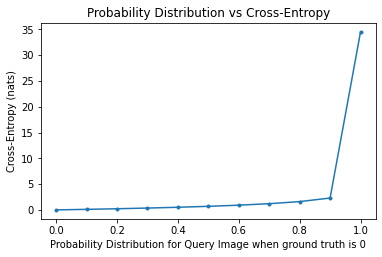

In [27]:
from math import log

# calculate cross-entropy
def cross_entropy(p, q, ets=1e-15):
    return -sum([p[i]*log(q[i]+ets) for i in range(len(p))])

def binary_cross_entropy(y_true, y_pred, eps=1e-15):
    return -(y_true[0] * log(y_pred[0]+eps) + y_true[1] * log(y_pred[1]+eps))

# define the target distribution for two events
target = [0.0, 1.0]
# define probabilities for the first event
probs = [
    [0.0, 1.0], # cat is 0% and dog is 100% confidence
    [0.1, 0.9],
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5],
    [0.6, 0.4],
    [0.7, 0.3],
    [0.8, 0.2],
    [0.9, 0.1],
    [1.0, 0.0],
]

# create probability distributions for the two events
# dists = [[1.0 - p, p] for p in probs]
# calculate cross-entropy for each distribution
ents = [binary_cross_entropy(y_true=target, y_pred=d) for d in probs]
# plot probability distribution vs cross-entropy
pyplot.plot([p[1] for p in probs], ents, marker='.')
pyplot.title('Probability Distribution vs Cross-Entropy')
#pyplot.xticks([1-p for p in probs], ['[%.1f,%.1f]'%(d[0],d[1]) for d in dists], rotation=70)
pyplot.subplots_adjust(bottom=0.2)
pyplot.xlabel('Probability Distribution for Query Image when ground truth is 1')
pyplot.ylabel('Cross-Entropy (nats)')
pyplot.show()

- [analytics-vidhya-entropy-loss](https://medium.com/analytics-vidhya/understanding-entropy-the-golden-measurement-of-machine-learning-4ea97c663dc3#:~:text=By%20using%20entropy%20in%20machine,be%20desired%20in%20model%2Dbuilding.)
- [cross-entropy-loss-machine-learning-mastery](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)
- [entropy-how-decision-trees-make-decisions](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8)
- https://ramsane.github.io/articles/cross-entropy-explained-with-entropy-and-kl-divergence
- https://neptune.ai/blog/cross-entropy-loss-and-its-applications-in-deep-learning

https://stackoverflow.com/questions/41990250/what-is-cross-entropy/41990932
https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
https://neptune.ai/blog/cross-entropy-loss-and-its-applications-in-deep-learning
https://machinelearningmastery.com/cross-entropy-for-machine-learning/
https://d2l.ai/chapter_linear-networks/softmax-regression.html
https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/geometry-linear-algebraic-ops.html#invertibility
https://leimao.github.io/blog/Cross-Entropy-KL-Divergence-MLE/
https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451
https://gist.github.com/yang-zhang/217dcc6ae9171d7a46ce42e215c1fee0
https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation
https://ramsane.github.io/articles/cross-entropy-explained-with-entropy-and-kl-divergence
